- Add a pass to identify disaster type and pass disaster type into damage net as a parameter

- Widen bounding box to compensate for off-nadir images

- Rotate polygon and clip to minimize area of bounding box, apply same rotation to image and then chip

- Train with the polygon mask painted on the image

- Diagram training process
- Add filters for bad chips (in distribution tails at levels that look like nonsense) for training -- do this once in preprocessing of "cleaned xBD" directory
- TTS model from baseline for damage.  Add bounding box channel
- Keras manual training loop in Jupyter
- Use CPU for inference
- Maybe recode baseline in chainer if I can figure out how to transfer the weights, so I can work in a single package and single process
- detect bad chips
- SR 30 end to end 100%
- 1 example for each disaster and damage type 100%
- threshold size for localization to reduce   fragments
- break out all scores per chip to spot hard cases systematically
- use image display liberally on all steps in process flow for sanity check

I will try making the smallest set of images that contains one of each incident and per incident one of each damage level, then see if I can overtrain my model individually to match grou d truth for each of these images.   This is to verify sizing and capacity.  And shake out bugs like the 1 pixel chips.  Then worry about training and then take all the money.  The plan should always end with take all the money, not some ego preserving excuse about self betterment.

https://towardsdatascience.com/keras-custom-training-loop-59ce779d60fb

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qhull_2d import *
from min_bounding_rect import *

from PIL import Image
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import math
import random
import argparse
import logging
import json
import cv2
import datetime

import shapely.wkt
import shapely
from shapely.geometry import Polygon, Point
from collections import defaultdict
from sklearn.model_selection import train_test_split
logging.basicConfig(level=logging.INFO)

In [3]:
from process_img_border import process_img_border

In [4]:
# Configurations
NUM_WORKERS = 4
NUM_CLASSES = 4
BATCH_SIZE = 64
NUM_EPOCHS = 120
LEARNING_RATE = 0.0001
RANDOM_SEED = 123
LOG_STEP = 150

damage_intensity_encoding = defaultdict(lambda: 0)
damage_intensity_encoding['destroyed'] = 3
damage_intensity_encoding['major-damage'] = 2
damage_intensity_encoding['minor-damage'] = 1
damage_intensity_encoding['no-damage'] = 0

In [5]:
input_path='/home/catskills/Desktop/dataxv2/xBD'

x_data = []
y_data = []

disasters = [folder for folder in os.listdir(input_path) if not folder.startswith('.')]
disaster_paths = ([input_path + "/" +  d + "/images" for d in disasters])
image_paths = []
image_paths.extend([(disaster_path + "/" + pic) for pic in os.listdir(disaster_path)] for disaster_path in disaster_paths)
img_paths = np.concatenate(image_paths)

image_info=[]

for img_path in img_paths:
    img_obj = Image.open(img_path)
    img_array = np.array(img_obj)
    label_path = img_path.replace('png', 'json').replace('images', 'labels')
    label_file = open(label_path)
    label_data = json.load(label_file)
    for feat in label_data['features']['xy']:
        try:
            damage_type = feat['properties']['subtype']
        except: # pre-disaster damage is default no-damage
            damage_type = "no-damage"
            continue
        polygon_geom = shapely.wkt.loads(feat['wkt'])
        polygon_pts = np.array(list(polygon_geom.exterior.coords))
        poly_img = process_img_border(img_array, polygon_pts)
        image_info.append((poly_img.shape, img_path, feat['properties']['uid'], poly_img))

## A big diagonally oriented chip comprising multiple buildings

In [6]:
oneA = [x for x in image_info if x[0][0] < 8]
oneB = [x for x in image_info if x[0][1] < 7]
big=[x for x in image_info if x[0][0]*x[0][1]>600**2]

print(len(oneA),len(oneB),len(big))

8 0 2


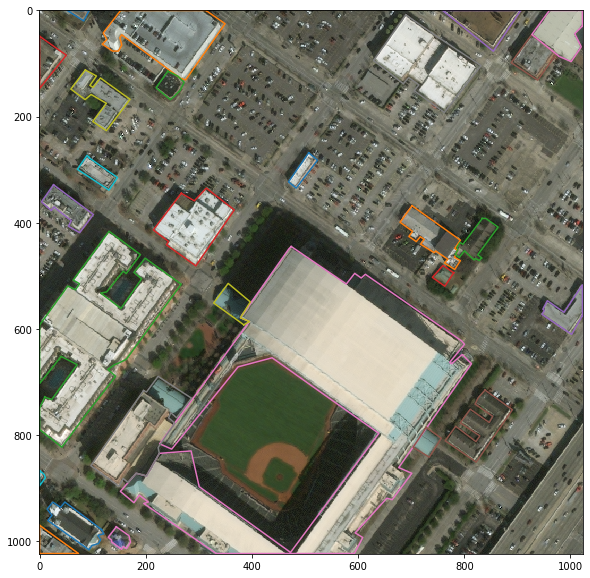

In [7]:
img_path=big[1][1]
img_path_pre=img_path.replace('_post_', '_pre_')
img_array_pre=np.array(Image.open(img_path_pre))
img_obj = Image.open(img_path)
img_array = np.array(img_obj)
label_path = img_path.replace('png', 'json').replace('images', 'labels')
label_file = open(label_path)
label_data = json.load(label_file)
plt.figure(figsize=(10,10))
plt.imshow(img_array_pre)
for feat in label_data['features']['xy']:
        try:
            damage_type = feat['properties']['subtype']
        except: # pre-disaster damage is default no-damage
            damage_type = "no-damage"
            continue
        polygon_geom= shapely.wkt.loads(feat['wkt'])
        polygon_pts = np.array(list(polygon_geom.exterior.coords))
        poly_img = process_img_border(img_array, polygon_pts)
        plt.plot(polygon_pts[:,0], polygon_pts[:,1])

## Chip distribution

In [8]:
dimensions=[x[0][0:2] for x in image_info]

Text(0, 0.5, '# images out of 162,787')

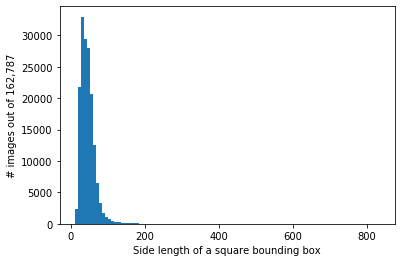

In [9]:
S=list(sorted([np.sqrt(x*y) for x,y in dimensions]))
plt.hist(S,bins=100);
plt.xlabel('Side length of a square bounding box')
plt.ylabel("# images out of 162,787")

## Mask out image and rotate to minimum area chip

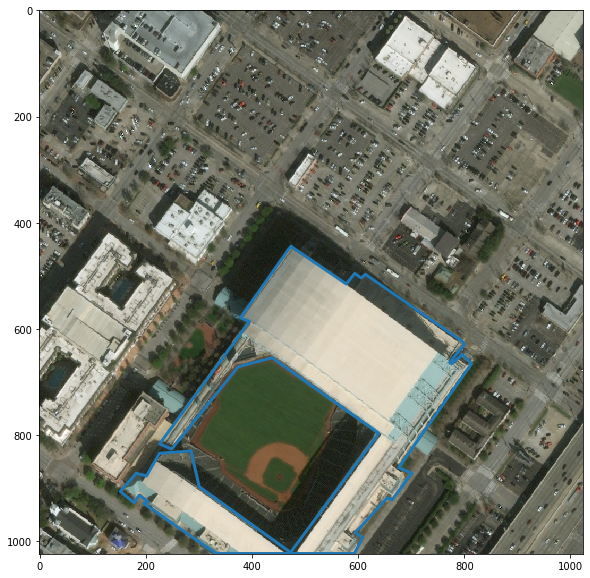

In [10]:
img_path='/home/catskills/Desktop/dataxv2/xBD/hurricane-harvey/images/hurricane-harvey_00000017_post_disaster.png'
img_path_pre=img_path.replace('_post_', '_pre_')
img_array_pre=np.array(Image.open(img_path_pre))
img_obj = Image.open(img_path)
img_array = np.array(img_obj)
label_path = img_path.replace('png', 'json').replace('images', 'labels')
label_file = open(label_path)
label_data = json.load(label_file)
plt.figure(figsize=(10,10))
plt.imshow(img_array_pre)
for feat in label_data['features']['xy']:
        try:
            damage_type = feat['properties']['subtype']
        except: # pre-disaster damage is default no-damage
            damage_type = "no-damage"
            continue
        polygon_geom= shapely.wkt.loads(feat['wkt'])
        polygon_pts = np.array(list(polygon_geom.exterior.coords))
        if feat['properties']['uid']=='529fbc55-a095-4b6a-a8f7-9cc9a93a5b44':
            plt.plot(polygon_pts[:,0], polygon_pts[:,1], linewidth=3.0)
            break

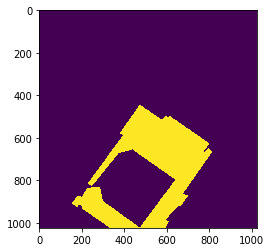

In [11]:
from matplotlib.path import Path
width, height=1024, 1024
poly_path=Path(polygon_pts)
x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
mask = poly_path.contains_points(coors).reshape(height, width).T
plt.imshow(mask);

(150, 850)

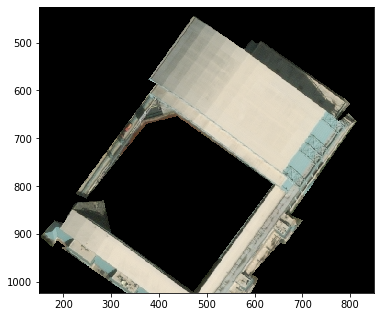

In [12]:
img_masked=np.zeros(img_array_pre.shape,dtype=img_array_pre.dtype)
img_masked[mask]=img_array_pre[mask]
plt.figure(figsize=(6,6))
plt.imshow(img_masked);
plt.ylim(1023,425)
plt.xlim(150,850)

Testing 12 possible rotations for bounding box... 



(150, 850)

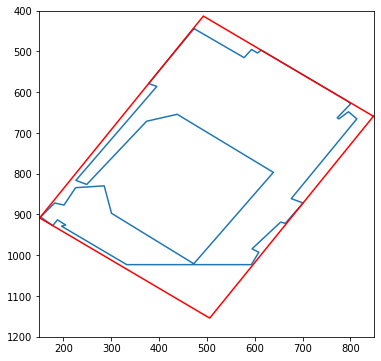

In [13]:
from qhull_2d import *
from min_bounding_rect import *
xy_points=polygon_pts
hull_points = qhull2D(xy_points)
hull_points = hull_points[::-1]
(rot_angle, area, width, height, center_point, corner_points) = minBoundingRect(hull_points)
plt.figure(figsize=(6,6))
plt.plot(polygon_pts[:,0], polygon_pts[:,1])
plt.plot(corner_points[:,0], corner_points[:,1], color='red')
plt.ylim(1200,400)
plt.xlim(150,850)

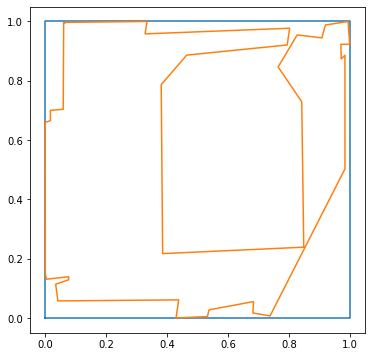

In [14]:
from skimage.transform import ProjectiveTransform
t = ProjectiveTransform()
src = corner_points[0:-1]
dst = np.asarray([[0, 0], [0, 1], [1, 1], [1, 0]])
if not t.estimate(src, dst): raise Exception("estimate failed")
data_local=t(polygon_pts)
plt.figure(figsize=(6,6))
plt.plot(dst[[0,1,2,3,0], 0], dst[[0,1,2,3,0], 1], '-')
plt.plot(data_local.T[0], data_local.T[1])

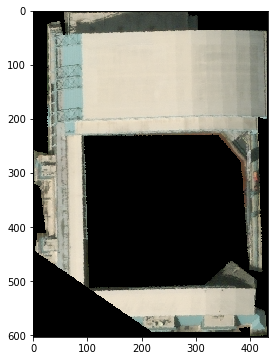

In [15]:
H=np.ceil(height).astype(int)
W=np.ceil(width).astype(int)
chip=np.zeros((H+1,W+1,3)).astype(img_masked.dtype)
x2, y2 = np.mgrid[:H, :W]
crds=np.hstack((x2.reshape(-1, 1), y2.reshape(-1,1))).astype(int)
crds1 = crds/np.array([H,W])
scrds=np.minimum(np.round(t.inverse(crds1)[:,::-1]).astype(int), 1023)
for i in range(scrds.shape[0]):
    (xt,yt)=crds[i]
    (xs,ys)=scrds[i]
    pixel=img_masked[xs,ys]
    chip[xt,yt]=pixel
plt.figure(figsize=(6,6))
plt.imshow(chip);

## Widen bounding box to compensate for off-nadir images

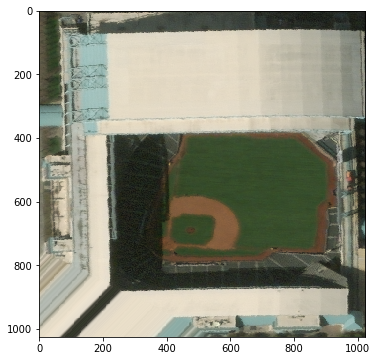

In [26]:
H=np.ceil(height).astype(int)
W=np.ceil(width).astype(int)
chip_pre=np.zeros((H+1,W+1,3)).astype(img_array_pre.dtype)
x2, y2 = np.mgrid[:H, :W]
crds=np.hstack((x2.reshape(-1, 1), y2.reshape(-1,1))).astype(int)
crds1 = crds/np.array([H,W])
scrds=np.minimum(np.round(t.inverse(crds1)[:,::-1]).astype(int), 1023)
for i in range(scrds.shape[0]):
    (xt,yt)=crds[i]
    (xs,ys)=scrds[i]
    pixel=img_array_pre[xs,ys]
    chip_pre[xt,yt]=pixel
plt.figure(figsize=(6,6))
plt.imshow(chip_pre);

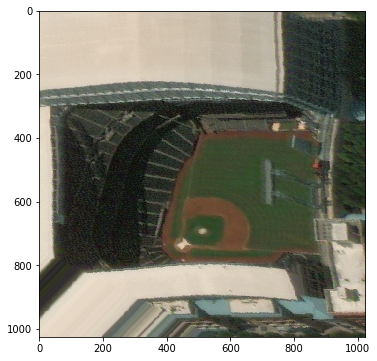

In [27]:
chip_post=np.zeros((H+1,W+1,3)).astype(img_array_post.dtype)
for i in range(scrds.shape[0]):
    (xt,yt)=crds[i]
    (xs,ys)=scrds[i]
    pixel=img_array_post[xs,ys]
    chip_post[xt,yt]=pixel
plt.figure(figsize=(6,6))
plt.imshow(chip_post);

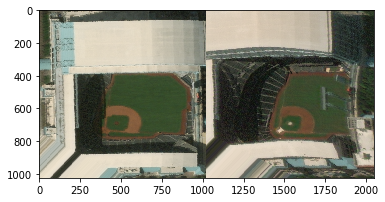

In [28]:
plt.imshow(np.hstack([chip_pre,chip_post]))

In [29]:
from skimage.transform import resize

In [30]:
chip_pre_small=resize(chip_pre,(256,127),anti_aliasing=True)

In [32]:
chip_post_small=resize(chip_post,(256,127),anti_aliasing=True)

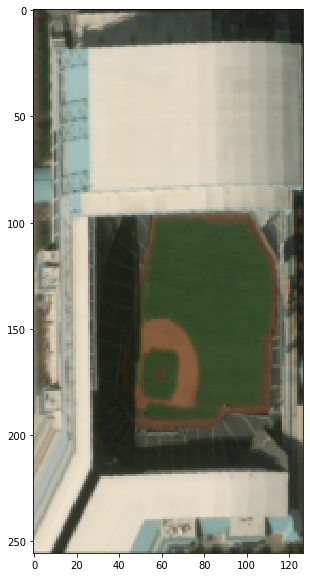

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(chip_pre_small)

In [35]:
chip=np.zeros((256,256,3)).astype(chip_pre_small.dtype)

In [36]:
chip_pre_small.shape

(256, 127, 3)

In [46]:
chip.shape

(256, 256, 3)

In [50]:
chip[:,0:127,:].shape, chip[:,129:,:].shape

((256, 127, 3), (256, 127, 3))

In [47]:
chip_pre_small.shape, 

(256, 127, 3)

In [65]:
chip[:,0:127,:]=chip_pre_small*255

In [66]:
chip[:,129:,:]=chip_post_small*255

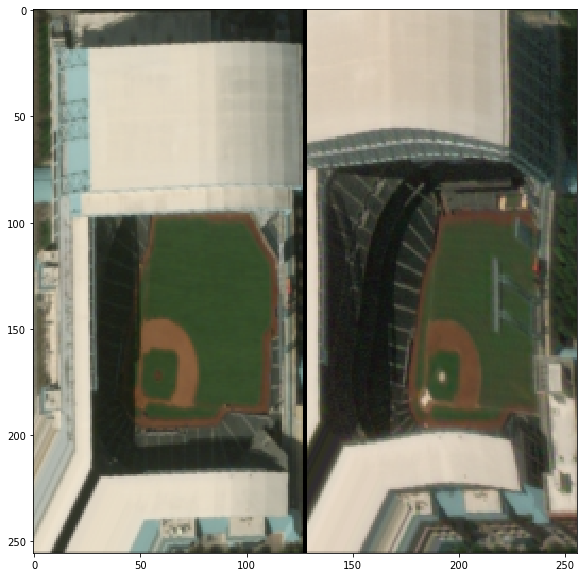

In [70]:
plt.figure(figsize=(10,10))
plt.imshow(chip)